In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy.typing as npt
from typing import *

In [3]:
gdf = gpd.read_file('/home/cas/Desktop/Hackathons/populationDensity_2024/EDs_2016_pop.geojson')

In [4]:
gdf = gdf.to_crs({'init': 'EPSG:29902'})

/nix/store/myw50bcivmfgx0cb6vqphl7289gk8lfl-python3-3.11.9-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
gdf['area_ha'] = gdf['geometry'].area *0.0001

In [6]:
gdf['2022_Density'] = gdf['2022_Population'] / gdf['area_ha']

In [7]:
# add NEIGHBORS column
gdf["NEIGHBORS"] = None  

for index, electoral_div in gdf.iterrows():   

    # get 'not disjoint' countries
    neighbors = gdf[~gdf.geometry.disjoint(electoral_div.geometry)].index.tolist()

    # remove own name of the country from the list
    neighbors = [ ed for ed in neighbors if electoral_div.index.tolist() != ed ]

    # add names of neighbors as NEIGHBORS value
    gdf.at[index, "NEIGHBORS"] = neighbors

In [8]:
# Making the adjacency matrix 

# We define an adj matrix list to record the index of neighbors for each ED 
proto_adj_matrix: list = []  # We do this to get around the irregular dimensions of the object
for index in range(len(gdf)): # Run through the EDs
    proto_adj_matrix.append(gdf.iloc[index].NEIGHBORS) # Add the ED's neighbors into proto adj matrix

# Define the Adj matrix as an n x n matrix of zeroes (where n = number of EDs)
adj_matrix: npt.ArrayLike = np.zeros([len(gdf), len(gdf)])

# Cycle through each ED and its respective list of neighbours
# Since an adj matrix is symmetric - this can be improved but numpy is sufficiently fast that at this scale it doesn't matter
for i, ed in enumerate(proto_adj_matrix):
    for neighbor in ed:
        if i != neighbor:
            adj_matrix[i][neighbor] = 1 # Set the relevant positions to 1 to indicate adjacency
        else:
            adj_matrix[i][neighbor] = 0

In [9]:
# Making the degree matrix

degree_matrix: npt.ArrayLike = np.diag([len(gdf.iloc[index].NEIGHBORS) for index, rows in gdf.iterrows()])

In [10]:
# Defining Laplacian matrix
# The Laplacian matrix (technically the negative Laplacian) is defined as the difference between the degree matrix and the adjacency matrix
# See: https://en.wikipedia.org/wiki/Laplacian_matrix

laplacian_matrix: npt.ArrayLike = degree_matrix - adj_matrix

The Diffusion Equation says that $\partial_t \mathbf{P} = \alpha^2 \; \partial^2 \mathbf{P}$. We convert this to a finite difference problem in $t$ and get:     
$\mathbf{P}(t+\Delta t) = \mathbf{P}(t) + (\partial^2 \mathbf{P}(t)) \cdot \Delta t$     
Now, we grab the initial population vector $\mathbf{P}$

In [11]:
# Pop Density Vector 

pop_vec: npt.ArrayLike = np.array([gdf['2022_Population'].iloc[index] for index, rows in gdf.iterrows()])

# Forcibly set population density for these trouble areas to 0 - this is fine as this code  is just a demonstration
for i in range(len(pop_vec)):
    if np.isnan(pop_vec[i]):
        pop_vec[i] = 0


In [12]:
# Define a solving function

def time_step_func(rho_vec: npt.ArrayLike, laplacian: npt.ArrayLike, delta_t: float, alpha: float) -> npt.ArrayLike:
    ''' 
    Takes one time step forward for solving the diffusion equation

    Args:
        rho_vec (npt.ArrayLike): A population density vector at time t
        laplacian (npt.ArrayLike): A graph laplacian matrix
        delta_t (float): Time increment

    Returns:
        npt.ArrayLike: The population density vector at time t + delta t
    ''' 
    return rho_vec - alpha**2 * laplacian @ rho_vec.T * delta_t

def solving_function(rho_vec: npt.ArrayLike, laplacian: npt.ArrayLike, t0: float, delta_t: float, max_t: float, alpha: float) -> Tuple[npt.ArrayLike]:
    ''' 
     Takes one time step forward for solving the diffusion equation

    Args:
        rho_vec (npt.ArrayLike): A population density vector at time t
        laplacian (npt.ArrayLike): A graph laplacian matrix
        t0 (float): Initial time
        delta_t (float): Time increment
        max_t (float): max time to solve for

    Returns:
        full_history (npt.ArrayLike): A ~(max_t - t0)/ delta_t x len(rho_vec) matrix that contains the full history of the population density
        time_steps (npt.ArrayLike): An array that contains all the time points sampled
    '''

    full_history: npt.ArrayLike = np.zeros([len([i for i in np.arange(t0, max_t, delta_t)]), len(rho_vec) ]) # Define a matrix to keep track of all steps of the calculation
    time_steps: list = [] # A simple list to keep track of the time steps
    for i, t in enumerate(np.arange(t0, max_t, delta_t,)): # Iterate through the time steps
        full_history[i] = rho_vec # Take note of current population density
        rho_vec = time_step_func(rho_vec, laplacian, delta_t, alpha) # Update population Density
    full_history[-1] = rho_vec # Finish with final time step
    time_steps = np.array(time_steps) # Convert time_steps list -> array
    return full_history, time_steps
    

In [13]:
# Time evolve population density vector 

# All these parameters are arbitrary and are just for demonstration purposes
# Feel free to mess around

t0: float = 0
max_t: float = 144
delta_t: float  = 1
alpha: float = 25e-2

full_population_vecs, sampled_times = solving_function(pop_vec, laplacian_matrix, t0, delta_t, max_t, alpha)

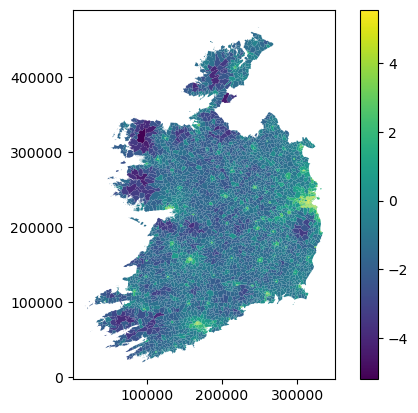

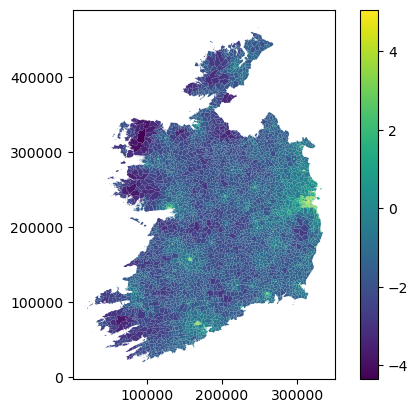

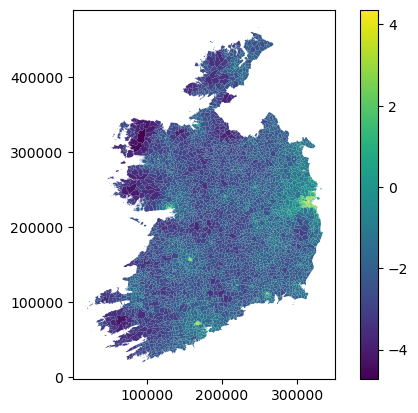

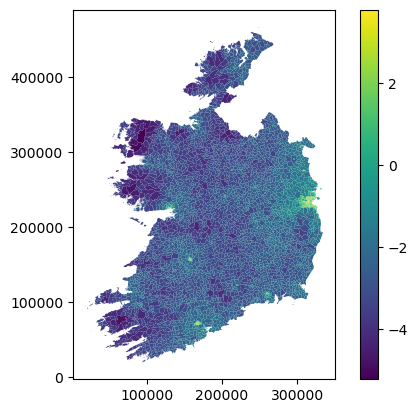

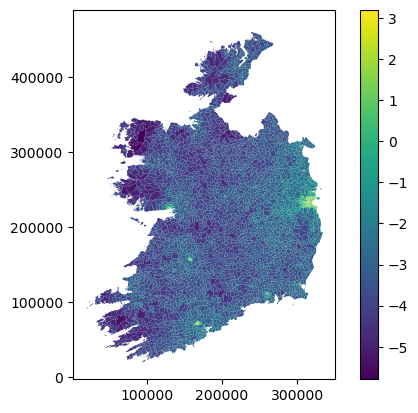

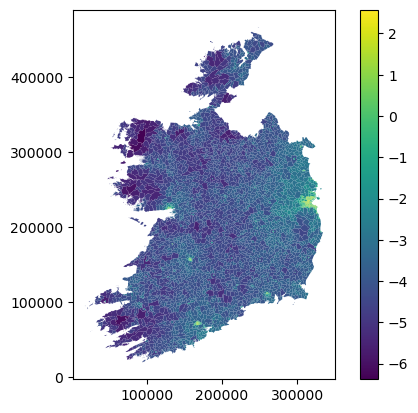

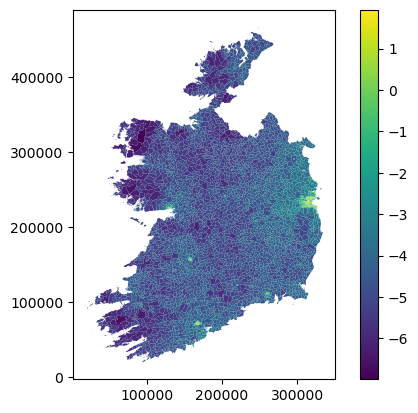

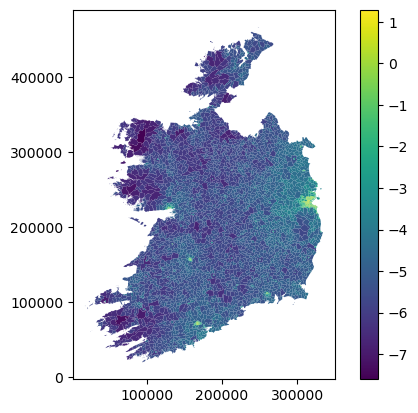

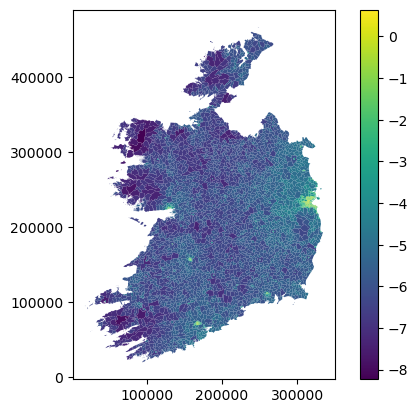

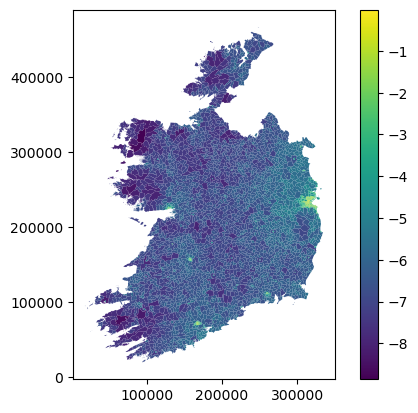

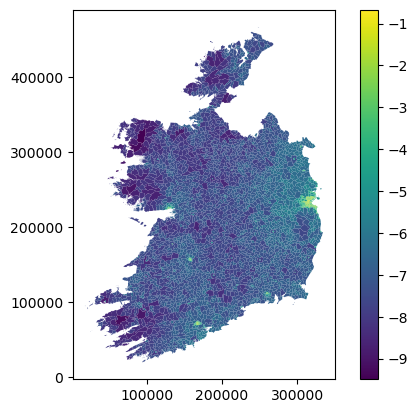

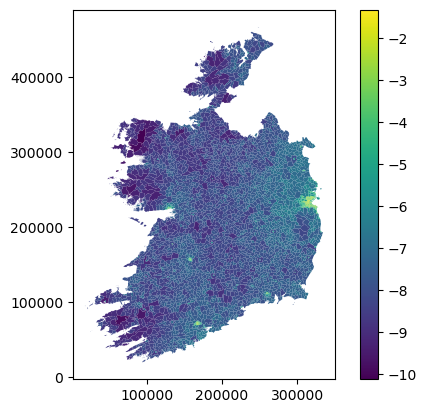

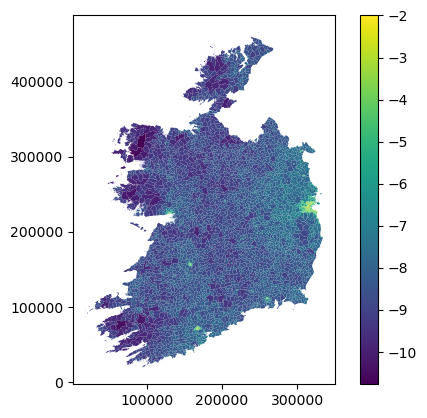

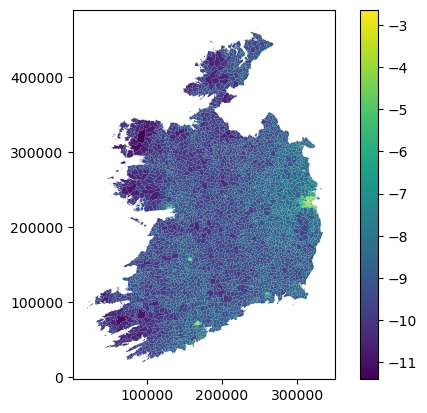

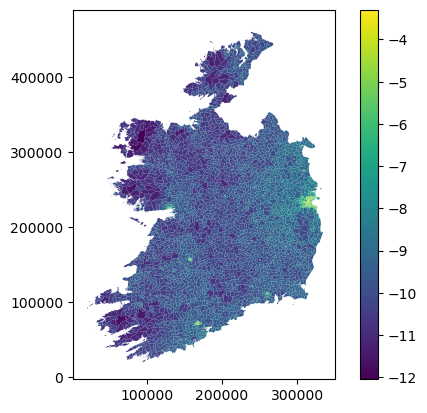

In [14]:
from copy import deepcopy
gdf_time_evolved = deepcopy(gdf) # We make a deep copy of the original geodataframe to avoid modifying the original
k: int = 0 # Counter for saving plots
for i in range(144):
    if i % 10 == 0:
        k += 1 # Increment counter
        gdf_time_evolved['New_Population'] = full_population_vecs[i] # Update the population
        gdf_time_evolved['density_to_plot'] = [np.log(row['New_Population']/row['area_ha']) for index, row in gdf_time_evolved.iterrows()] # Update the population density to plot
        ax = gdf_time_evolved.plot(column = "density_to_plot", legend = True, cmap = 'viridis')
        ax.plot()
        plt.savefig(f'./populationDensity_2024/diffusion_plots/plot_{k}.png')